In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from typing import Tuple

In [2]:
np.random.seed(42)

In [3]:
def generate_blobs(n_samples: int = 2000,
                   n_features: int = 2,
                   n_classes: int = 5,
                   cluster_std: float = 1.5,
                   centers: np.ndarray = None,
                   center_box: Tuple[float, float] = (-10, 10),
                   random_state: int = 42):

    rng = np.random.RandomState(random_state)
    if centers is None:
        centers = rng.uniform(center_box[0], center_box[1], size=(n_classes, n_features))
    assert centers.shape == (n_classes, n_features)
    samples_per_class = [n_samples // n_classes] * n_classes

    for i in range(n_samples - sum(samples_per_class)):
        samples_per_class[i % n_classes] += 1

    X_list = []
    y_list = []
    for class_idx in range(n_classes):
        mean = centers[class_idx]
        cov = (cluster_std ** 2) * np.eye(n_features)
        samples = rng.multivariate_normal(mean, cov, size=samples_per_class[class_idx])
        X_list.append(samples)
        y_list.append(np.full(samples_per_class[class_idx], class_idx, dtype=int))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    perm = rng.permutation(X.shape[0])
    return X[perm], y[perm]

In [4]:
def one_hot_encode(y: np.ndarray, num_classes: int) -> np.ndarray:
    m = y.shape[0]
    Y = np.zeros((m, num_classes))
    Y[np.arange(m), y] = 1
    return Y

def train_test_split(X: np.ndarray, y: np.ndarray, test_size: float = 0.2, random_state: int = 42):
    rng = np.random.RandomState(random_state)
    m = X.shape[0]
    perm = rng.permutation(m)
    test_count = int(np.floor(m * test_size))
    test_idx = perm[:test_count]
    train_idx = perm[test_count:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def compute_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, num_classes: int):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def compute_precision_recall_f1(cm: np.ndarray):

    tp = np.diag(cm).astype(float)
    support = cm.sum(axis=1).astype(float)
    predicted_counts = cm.sum(axis=0).astype(float)

    precision = np.zeros_like(tp)
    recall = np.zeros_like(tp)
    f1 = np.zeros_like(tp)

    for i in range(len(tp)):
        precision[i] = tp[i] / predicted_counts[i] if predicted_counts[i] > 0 else 0.0
        recall[i] = tp[i] / support[i] if support[i] > 0 else 0.0
        if precision[i] + recall[i] > 0:
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        else:
            f1[i] = 0.0

    return precision, recall, f1, support


In [12]:
class NeuralNetwork:


    def __init__(self, input_dim: int, hidden_dims: tuple, output_dim: int, weight_scale=0.01, seed: int = None):

        if seed is not None:
            np.random.seed(seed)
        assert len(hidden_dims) == 3,
        dims = [input_dim] + list(hidden_dims) + [output_dim]
        self.params = {}
        for i in range(1, len(dims)):
            # Weight shape: (previous_layer_dim, next_layer_dim)
            self.params[f'W{i}'] = np.random.randn(dims[i-1], dims[i]) * weight_scale
            self.params[f'b{i}'] = np.zeros((1, dims[i]))

    @staticmethod
    def relu(Z):
        return np.maximum(0, Z)

    @staticmethod
    def relu_derivative(Z):
        return (Z > 0).astype(float)

    @staticmethod
    def softmax(Z):

        Z_shift = Z - np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(Z_shift)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(probs, Y_one_hot):

        m = Y_one_hot.shape[0]
        eps = 1e-15
        clipped = np.clip(probs, eps, 1 - eps)
        loss = -np.sum(Y_one_hot * np.log(clipped)) / m
        return loss

    def forward(self, X):

        cache = {}
        cache['A0'] = X

        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        cache['Z1'], cache['A1'] = Z1, A1

        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = self.relu(Z2)
        cache['Z2'], cache['A2'] = Z2, A2

        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        A3 = self.relu(Z3)
        cache['Z3'], cache['A3'] = Z3, A3

        Z4 = A3.dot(self.params['W4']) + self.params['b4']
        A4 = self.softmax(Z4)
        cache['Z4'], cache['A4'] = Z4, A4
        return A4, cache

    def backward(self, cache, Y_one_hot):

        grads = {}
        m = Y_one_hot.shape[0]
        A0 = cache['A0']
        A1 = cache['A1']
        A2 = cache['A2']
        A3 = cache['A3']
        A4 = cache['A4']

        dZ4 = (A4 - Y_one_hot) / m
        grads['dW4'] = A3.T.dot(dZ4)
        grads['db4'] = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = dZ4.dot(self.params['W4'].T)
        dZ3 = dA3 * self.relu_derivative(cache['Z3'])
        grads['dW3'] = A2.T.dot(dZ3)
        grads['db3'] = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3.dot(self.params['W3'].T)
        dZ2 = dA2 * self.relu_derivative(cache['Z2'])
        grads['dW2'] = A1.T.dot(dZ2)
        grads['db2'] = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2.dot(self.params['W2'].T)
        dZ1 = dA1 * self.relu_derivative(cache['Z1'])
        grads['dW1'] = A0.T.dot(dZ1)
        grads['db1'] = np.sum(dZ1, axis=0, keepdims=True)

        return grads

    def update_params(self, grads, lr=1e-2):
        for i in range(1, 5):
            self.params[f'W{i}'] -= lr * grads[f'dW{i}']
            self.params[f'b{i}'] -= lr * grads[f'db{i}']

    def predict(self, X):
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=1)

    def fit(self, X, y, X_val=None, y_val=None, epochs=100, batch_size=64, lr=1e-2, verbose=True):

        m = X.shape[0]
        history = {'loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(1, epochs + 1):

            perm = np.random.permutation(m)
            X_shuff = X[perm]
            y_shuff = y[perm]

            epoch_loss = 0.0
            correct = 0

            for start in range(0, m, batch_size):
                end = min(start + batch_size, m)
                X_batch = X_shuff[start:end]
                y_batch = y_shuff[start:end]
                Y_one_hot = one_hot_encode(y_batch, self.params['b4'].shape[1])

                probs, cache = self.forward(X_batch)
                loss = self.cross_entropy_loss(probs, Y_one_hot)
                epoch_loss += loss * (end - start)
                preds = np.argmax(probs, axis=1)
                correct += np.sum(preds == y_batch)

                grads = self.backward(cache, Y_one_hot)
                self.update_params(grads, lr=lr)

            epoch_loss /= m
            train_acc = correct / m
            history['loss'].append(epoch_loss)
            history['train_acc'].append(train_acc)

            if X_val is not None and y_val is not None:
                val_probs, _ = self.forward(X_val)
                val_loss = self.cross_entropy_loss(val_probs, one_hot_encode(y_val, self.params['b4'].shape[1]))
                val_preds = np.argmax(val_probs, axis=1)
                val_acc = np.mean(val_preds == y_val)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                if verbose and (epoch % max(1, epochs // 10) == 0 or epoch in (1, epochs)):
                    print(f"Epoch {epoch}/{epochs} - loss: {epoch_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
            else:
                if verbose and (epoch % max(1, epochs // 10) == 0 or epoch in (1, epochs)):
                    print(f"Epoch {epoch}/{epochs} - loss: {epoch_loss:.4f} - acc: {train_acc:.4f}")

        return history

Dataset shapes: (2400, 2) (600, 2) (2400,) (600,)


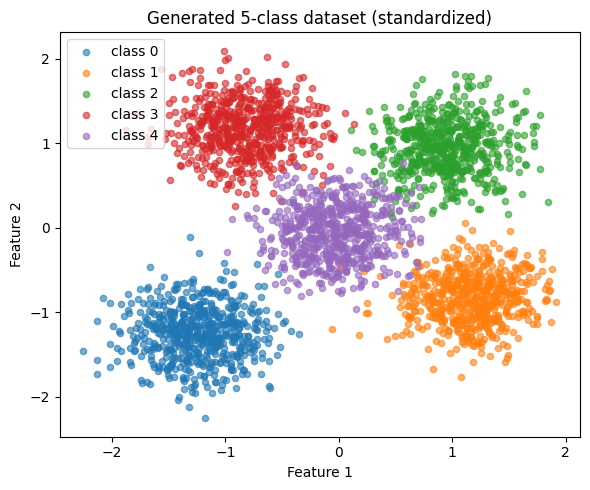

Epoch 1/120 - loss: 1.6055 - acc: 0.2375 - val_loss: 1.6025 - val_acc: 0.1767
Epoch 12/120 - loss: 0.1728 - acc: 0.9700 - val_loss: 0.1523 - val_acc: 0.9683
Epoch 24/120 - loss: 0.0517 - acc: 0.9833 - val_loss: 0.0500 - val_acc: 0.9833
Epoch 36/120 - loss: 0.0435 - acc: 0.9838 - val_loss: 0.0458 - val_acc: 0.9850
Epoch 48/120 - loss: 0.0417 - acc: 0.9842 - val_loss: 0.0501 - val_acc: 0.9833
Epoch 60/120 - loss: 0.0414 - acc: 0.9846 - val_loss: 0.0473 - val_acc: 0.9850
Epoch 72/120 - loss: 0.0412 - acc: 0.9829 - val_loss: 0.0518 - val_acc: 0.9800
Epoch 84/120 - loss: 0.0408 - acc: 0.9833 - val_loss: 0.0500 - val_acc: 0.9833
Epoch 96/120 - loss: 0.0410 - acc: 0.9846 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 108/120 - loss: 0.0389 - acc: 0.9854 - val_loss: 0.0477 - val_acc: 0.9867
Epoch 120/120 - loss: 0.0377 - acc: 0.9858 - val_loss: 0.0423 - val_acc: 0.9833


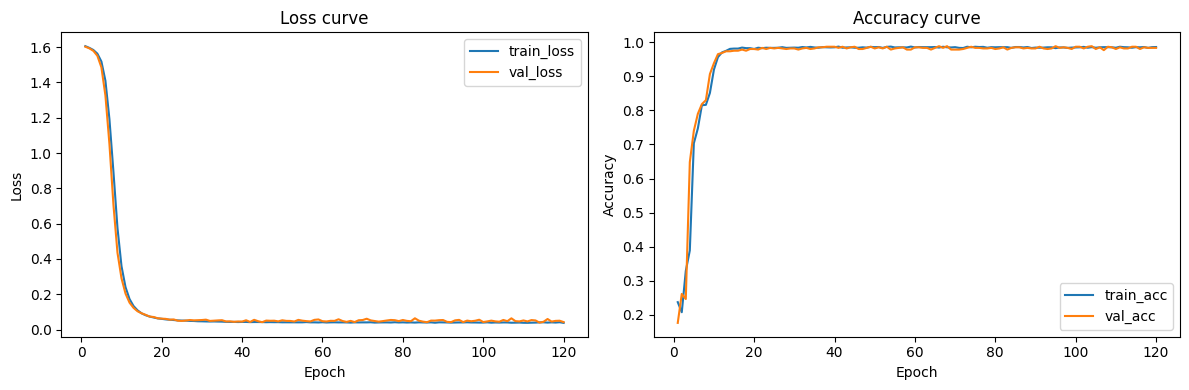


Test accuracy: 0.9833

Per-class metrics:
Class 0: Precision = 0.9931, Recall = 0.9931, F1 = 0.9931, Support = 144
Class 1: Precision = 0.9764, Recall = 1.0000, F1 = 0.9880, Support = 124
Class 2: Precision = 0.9813, Recall = 0.9906, F1 = 0.9859, Support = 106
Class 3: Precision = 0.9908, Recall = 0.9908, F1 = 0.9908, Support = 109
Class 4: Precision = 0.9735, Recall = 0.9402, F1 = 0.9565, Support = 117

Macro Precision: 0.9830, Macro Recall: 0.9829, Macro F1: 0.9829


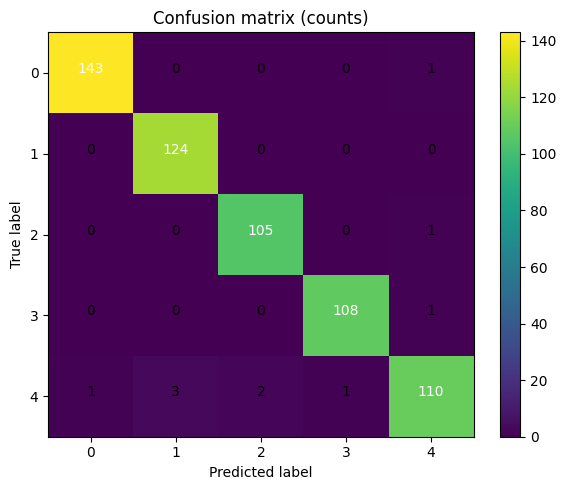

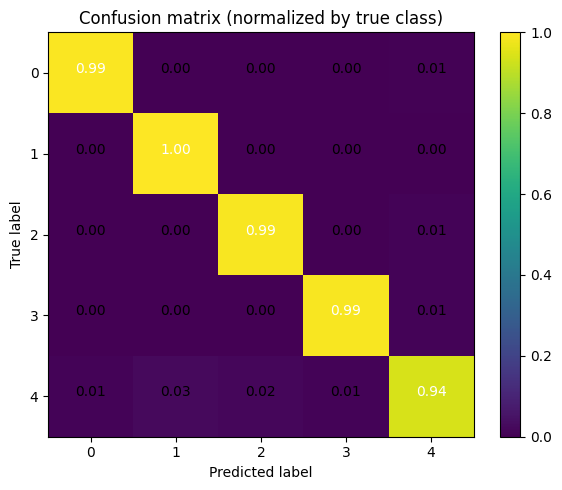

In [10]:
def plot_data(X, y, title="Data (2D)"):
    plt.figure(figsize=(6, 5))
    for label in np.unique(y):
        plt.scatter(X[y == label, 0], X[y == label, 1], label=f"class {label}", alpha=0.6, s=20)
    plt.legend()
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

def plot_history(history):
    epochs = len(history['loss'])
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), history['loss'], label='train_loss')
    if history.get('val_loss'):
        plt.plot(range(1, epochs + 1), history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss curve'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), history['train_acc'], label='train_acc')
    if history.get('val_acc'):
        plt.plot(range(1, epochs + 1), history['val_acc'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy curve'); plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm_to_show = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
    else:
        cm_to_show = cm
    plt.figure(figsize=(6, 5))
    plt.imshow(cm_to_show, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm_to_show.max() / 2.
    for i, j in itertools.product(range(cm_to_show.shape[0]), range(cm_to_show.shape[1])):
        plt.text(j, i, format(cm_to_show[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_to_show[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def main():

    n_samples = 3000
    n_features = 2
    n_classes = 5
    cluster_std = 1.6
    hidden_dims = (64, 32, 16)
    weight_scale = 0.1
    epochs = 120
    batch_size = 64
    lr = 0.05
    test_size = 0.2

    centers = np.array([
        [-6.0, -6.0],
        [6.0, -4.0],
        [5.0, 5.0],
        [-4.0, 6.0],
        [0.0, 0.0]
    ])
    X, y = generate_blobs(n_samples=n_samples, n_features=n_features, n_classes=n_classes,
                          cluster_std=cluster_std, centers=centers, random_state=123)


    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-12
    X = (X - X_mean) / X_std

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    print("Dataset shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


    plot_data(X, y, title="Generated 5-class dataset (standardized)")


    model = NeuralNetwork(input_dim=n_features, hidden_dims=hidden_dims, output_dim=n_classes,
                          weight_scale=weight_scale, seed=1)


    history = model.fit(X_train, y_train, X_val=X_test, y_val=y_test,
                        epochs=epochs, batch_size=batch_size, lr=lr, verbose=True)


    plot_history(history)

    y_pred = model.predict(X_test)
    acc = np.mean(y_pred == y_test)
    print(f"\nTest accuracy: {acc:.4f}")

    cm = compute_confusion_matrix(y_test, y_pred, num_classes=n_classes)
    precision, recall, f1, support = compute_precision_recall_f1(cm)

    print("\nPer-class metrics:")
    for i in range(n_classes):
        print(f"Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1 = {f1[i]:.4f}, Support = {int(support[i])}")


    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    micro_tp = np.sum(np.diag(cm))
    micro_fp = np.sum(cm) - micro_tp
    micro_precision = micro_tp / np.sum(cm, axis=0).sum() if np.sum(cm) > 0 else 0.0
    print(f"\nMacro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1: {macro_f1:.4f}")


    plot_confusion_matrix(cm, classes=[str(i) for i in range(n_classes)], normalize=False, title='Confusion matrix (counts)')
    plot_confusion_matrix(cm, classes=[str(i) for i in range(n_classes)], normalize=True, title='Confusion matrix (normalized by true class)')

if __name__ == "__main__":
    main()